**PM Lipidomics By Subclass**

In [1]:
# load packages
library(ggplot2)
library(ggsignif)
library(SingleCellExperiment)

Warning message:
"package 'ggsignif' was built under R version 3.6.3"Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sor

In [2]:
# load PM lipidomic data
data = readRDS('../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$pm_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

# sum lipidomic data by class
result <- aggregate(. ~ class, data = cts[cts$class %in% unique(class), ], sum)
rownames(result) = result$class
result$class = NULL
df =  as.data.frame(t(result))
total = rowSums(df)
genotype = colData(d)$LOF_status
df = as.data.frame(cbind(df, genotype, total))

In [2]:
# load PM lipidomic data
data = readRDS('../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$ngn2_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$total_unsaturation = rowData(d)$total_unsaturation
# Group into saturated, mono unsaturated and polyunsaturated
cts$saturation_group <- ifelse(cts$total_unsaturation == 0, 'Saturated',
                               ifelse(cts$total_unsaturation == 1, 'Monounsaturated', 'Polyunsaturated'))

cts$total_unsaturation = NULL
# Sum lipidomic data by saturation group
result <- aggregate(. ~ saturation_group, data = cts[class == 'PC', ], sum)

rownames(result) = result$saturation_group
result$saturation_group = NULL
df =  as.data.frame(t(result))
genotype = colData(d)$Genotype
treatment = colData(d)$treatment
names(df) = paste0('PC_', names(df))

df = as.data.frame(cbind(df, genotype))[treatment!='Choline',]

df

,PC_Monounsaturated,PC_Polyunsaturated,PC_Saturated,genotype
,<dbl>,<dbl>,<dbl>,<fct>
s1.1,5964493573,21631805763,2901116305,Control
s1.2,11461317827,42795341468,7113779245,Control
s1.3,10911465883,35344638228,5285354168,Control
s2.1,8852580182,34725218228,8755369221,ABCA7 LoF
s2.2,12273519384,48377211123,14090125930,ABCA7 LoF
s2.3,17039800378,60952009583,17168867365,ABCA7 LoF
s3.1,6998774553,26010765201,3400381169,Control
s3.2,10888348616,29905019972,4483202839,Control
s3.3,5854316353,23082033282,3078754462,Control


In [53]:
x$tot

[1] FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE
 [13] FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE
 [25] FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37]  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE
 [61] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE
 [73] FALSE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE
 [85] FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
[109] FALSE FALSE FALSE    NA FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE
[121]  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE

Warning message in cor.test.default(x$total_unsaturation, x$score_both_batch, method = "spearman"):
"Cannot compute exact p-value with ties"

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."`geom_smooth()` using formula = 'y ~ x'Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."`geom_smooth()` using formula = 'y ~ x'Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."

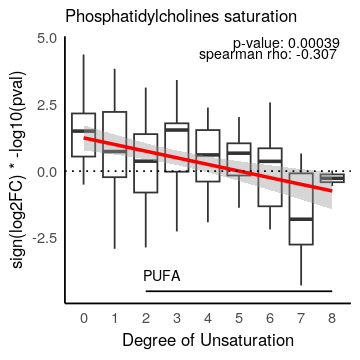

In [17]:
# Adjust figure size
options(repr.plot.width = 3, repr.plot.height = 3)

# Extract row data for PCs
x = as.data.frame(rowData(data$ngn2_all))

x$logfc = x$logfc_both_batch
x$fdr = p.adjust(x$pvals_both_batch, method = "fdr")

x = x[x$lipid.class == 'PC',]
# Compute Spearman correlation between total_unsaturation and score_both_batch

result <- cor.test(x$total_unsaturation, x$score_both_batch, method = "spearman")
# Add p-value and rho to the plot
p_value <- result$p.value
rho <- result$estimate
x$annotation = x$significant
# Plot boxplot of sign(logFC both batch) * -log10(pval both batch) against total unsaturation
ggplot(x, aes(x = as.factor(total_unsaturation), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA) +
  geom_smooth(method = "lm", aes(group = 1), color = "red", se = TRUE) +  # Add trend line
  labs(x = "Degree of Unsaturation", y = "sign(log2FC) * -log10(pval)", title = "Phosphatidylcholines saturation") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  ) +
# geom_jitter(
#     data = filter(x, pvals_both_batch<0.001 & abs(logfc_both_batch)>1),  # Filter data for TRUE annotations
#     width = 0.2,                            # Horizontal jitter
#     size = 1,                               # Increased size for visibility
#     alpha = 0.7,                            # Slightly higher opacity
#     color = "red"                           # Color for annotated points
#   ) +
  annotate("text", x = Inf, y = Inf, label = paste("p-value:", format(p_value, digits = 3)), hjust = 1.1, vjust = 1.1, size = 3, color = "black") +
  annotate("text", x = Inf, y = Inf, label = paste("spearman rho:", format(rho, digits = 3)), hjust = 1.1, vjust = 2.1, size = 3, color = "black") +
  geom_hline(yintercept = 0, linetype = "dotted", color = "black") + # Add horizontal dotted line at zero
  annotate("segment", x = 3, xend = 9, y = -4.5, yend = -4.5,  color = "black") +  # Add right arrow
  annotate("text", x = 3.5, y = -3.9, label = "PUFA", color = "black", size = 3)
ggsave("./pdf_figures/phospholipids_saturation.p", plot = last_plot(), device = "png", width = 3, height = 3)



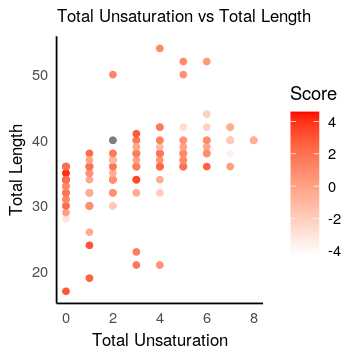

In [21]:
# Plot total unsaturation vs total length, color points by score
ggplot(x, aes(x = total_unsaturation, y = total_length, color = score_both_batch)) +
  geom_point() +
  scale_color_gradient(low = "white", high = "red") +  # Change color scheme to white-red
  labs(x = "Total Unsaturation", y = "Total Length", title = "Total Unsaturation vs Total Length", color = "Score") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  )

Warning message in cor.test.default(x$total_unsaturation, x$score_both_batch, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."

Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."

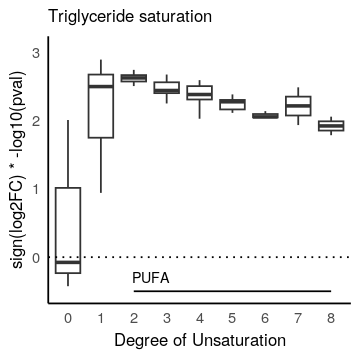

In [14]:
# Adjust figure size
options(repr.plot.width = 3, repr.plot.height = 3)

# Extract row data for PCs
x = as.data.frame(rowData(data$ngn2_all))
x$logfc = x$logfc_both_batch
x$fdr = p.adjust(x$pvals_both_batch, method = "fdr")

x = x[x$lipid.class == 'TG',]
# Compute Spearman correlation between total_unsaturation and score_both_batch

result <- cor.test(x$total_unsaturation, x$score_both_batch, method = "spearman")
# Add p-value and rho to the plot
p_value <- result$p.value
rho <- result$estimate

# Plot boxplot of sign(logFC both batch) * -log10(pval both batch) against total unsaturation
ggplot(x, aes(x = as.factor(total_unsaturation), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA) +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
  labs(x = "Degree of Unsaturation", y = "sign(log2FC) * -log10(pval)", title = "Triglyceride saturation") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  ) +
  # geom_jitter(
  #   data = filter(x, fdr<0.05 & abs(logfc_both_batch)>1),  # Filter data for TRUE annotations
  #   width = 0.2,                            # Horizontal jitter
  #   size = 1,                               # Increased size for visibility
  #   alpha = 0.7,                            # Slightly higher opacity
  #   color = "red"                           # Color for annotated points
  # ) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "black") +
  annotate("segment", x = 3, xend = 9, y = -0.5, yend = -0.5,  color = "black") +  # Add right arrow
  annotate("text", x = 3.5, y = -.3, label = "PUFA", color = "black", size = 3)  # Add horizontal dotted line at zero
ggsave("./pdf_figures/triglycerides_saturation.pdf", plot = last_plot(), device = "pdf", width = 3, height = 3)

# Add right arrow annotation to the plot




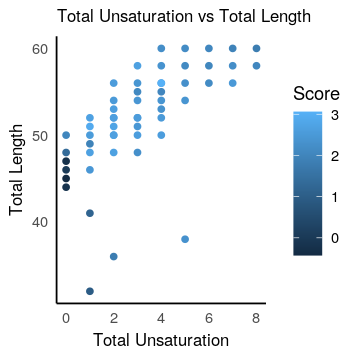

In [16]:
# Plot total unsaturation vs total length, color points by score
ggplot(x, aes(x = total_unsaturation, y = total_length, color = score_both_batch)) +
  geom_point() +
  labs(x = "Total Unsaturation", y = "Total Length", title = "Total Unsaturation vs Total Length", color = "Score") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  )

In [7]:
names(x)

[1] "lipid.name"                    "lipid.ret_time"               
 [3] "lipid.rej."                    "lipid.lipidion"               
 [5] "lipid.lipidgroup"              "lipid.class"                  
 [7] "lipid.fattyacid"               "lipid.fa1"                    
 [9] "lipid.fa2"                     "lipid.fa3"                    
[11] "lipid.calcmz"                  "lipid.ionformula"             
[13] "stats.ratio.s2.over.s1."       "stats.log_ratio.s2.over.s1."  
[15] "stats.p_value.s2.over.s1."     "stats.log_p_value.s2.over.s1."
[17] "stats.ratio.s4.over.s3."       "stats.log_ratio.s4.over.s3."  
[19] "stats.p_value.s4.over.s3."     "stats.log_p_value.s4.over.s3."
[21] "stats.ratio.s5.over.s3."       "stats.log_ratio.s5.over.s3."  
[23] "stats.p_value.s5.over.s3."     "stats.log_p_value.s5.over.s3."
[25] "total_unsaturation"            "mean_length"                  
[27] "total_length"                  "names"                        
[29] "merge_index"                   "max_length"                   
[31] "min_length"                    "pvals_both_batch"             
[33] "logfc_both_batch"              "score_both_batch"             
[35] "logfc"                         "fdr"

Warning message in cor.test.default(x$total_unsaturation, x$score_both_batch, method = "spearman"):
"Cannot compute exact p-value with ties"

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."

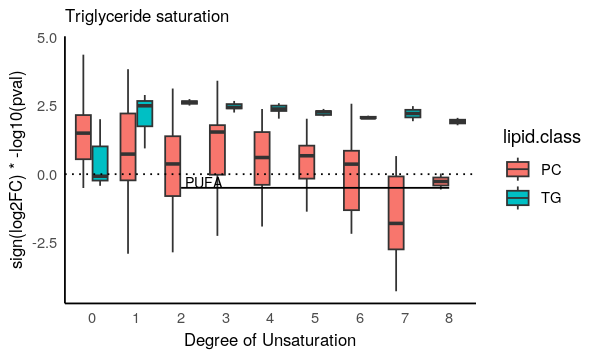

In [35]:
# Adjust figure size
options(repr.plot.width = 5, repr.plot.height = 3)

# Extract row data for PCs
x = as.data.frame(rowData(data$ngn2_all))
x$logfc = x$logfc_both_batch
x$fdr = p.adjust(x$pvals_both_batch, method = "fdr")

x = x[x$lipid.class%in%c('PC', 'TG'),]
# Compute Spearman correlation between total_unsaturation and score_both_batch

result <- cor.test(x$total_unsaturation, x$score_both_batch, method = "spearman")
# Add p-value and rho to the plot
p_value <- result$p.value
rho <- result$estimate
x$chain_length_category <- cut(x$mean_length,
                               breaks = c(-Inf, 6, 12, 21, Inf),
                               labels = c("Short-Chain Fatty Acids (SCFAs)",
                                          "Medium-Chain Fatty Acids (MCFAs)",
                                          "Long-Chain Fatty Acids (LCFAs)",
                                          "Very Long-Chain Fatty Acids (VLCFAs)"))

# Plot boxplot of sign(logFC both batch) * -log10(pval both batch) against total unsaturation
ggplot(x, aes(x = as.factor(total_unsaturation), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA, aes(fill=lipid.class)) +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
  labs(x = "Degree of Unsaturation", y = "sign(log2FC) * -log10(pval)", title = "Triglyceride saturation") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  ) +
  # geom_jitter(
  #   data = filter(x, fdr<0.05 & abs(logfc_both_batch)>1),  # Filter data for TRUE annotations
  #   width = 0.2,                            # Horizontal jitter
  #   size = 1,                               # Increased size for visibility
  #   alpha = 0.7,                            # Slightly higher opacity
  #   color = "red"                           # Color for annotated points
  # ) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "black") +
  annotate("segment", x = 3, xend = 9, y = -0.5, yend = -0.5,  color = "black") +  # Add right arrow
  annotate("text", x = 3.5, y = -.3, label = "PUFA", color = "black", size = 3)  # Add horizontal dotted line at zero
#ggsave("./pdf_figures/triglycerides_saturation.pdf", plot = last_plot(), device = "pdf", width = 3, height = 3)

# Add right arrow annotation to the plot




Warning message in cor.test.default(x$total_unsaturation, x$score_both_batch, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."

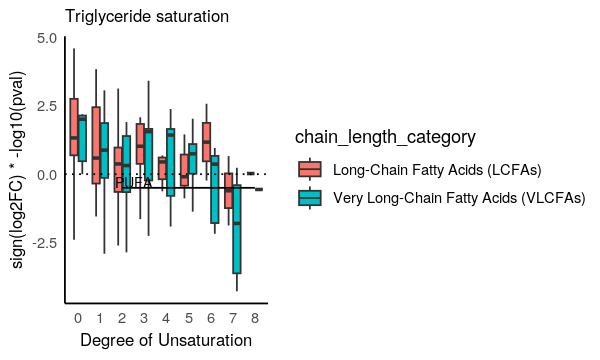

In [36]:
# Adjust figure size
options(repr.plot.width = 5, repr.plot.height = 3)

# Extract row data for PCs
x = as.data.frame(rowData(data$ngn2_all))
x$logfc = x$logfc_both_batch
x$fdr = p.adjust(x$pvals_both_batch, method = "fdr")

x = x[x$lipid.class%in%c('PC'),]
# Compute Spearman correlation between total_unsaturation and score_both_batch

result <- cor.test(x$total_unsaturation, x$score_both_batch, method = "spearman")
# Add p-value and rho to the plot
p_value <- result$p.value
rho <- result$estimate
x$chain_length_category <- cut(x$mean_length,
                               breaks = c(-Inf, 6, 12, 21, Inf),
                               labels = c("Short-Chain Fatty Acids (SCFAs)",
                                          "Medium-Chain Fatty Acids (MCFAs)",
                                          "Long-Chain Fatty Acids (LCFAs)",
                                          "Very Long-Chain Fatty Acids (VLCFAs)"))

# Plot boxplot of sign(logFC both batch) * -log10(pval both batch) against total unsaturation
ggplot(x, aes(x = as.factor(total_unsaturation), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA, aes(fill=chain_length_category)) +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
  labs(x = "Degree of Unsaturation", y = "sign(log2FC) * -log10(pval)", title = "Triglyceride saturation") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  ) +
  # geom_jitter(
  #   data = filter(x, fdr<0.05 & abs(logfc_both_batch)>1),  # Filter data for TRUE annotations
  #   width = 0.2,                            # Horizontal jitter
  #   size = 1,                               # Increased size for visibility
  #   alpha = 0.7,                            # Slightly higher opacity
  #   color = "red"                           # Color for annotated points
  # ) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "black") +
  annotate("segment", x = 3, xend = 9, y = -0.5, yend = -0.5,  color = "black") +  # Add right arrow
  annotate("text", x = 3.5, y = -.3, label = "PUFA", color = "black", size = 3)  # Add horizontal dotted line at zero
#ggsave("./pdf_figures/triglycerides_saturation.pdf", plot = last_plot(), device = "pdf", width = 3, height = 3)


Warning message in cor.test.default(x$total_unsaturation, x$score_both_batch, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."

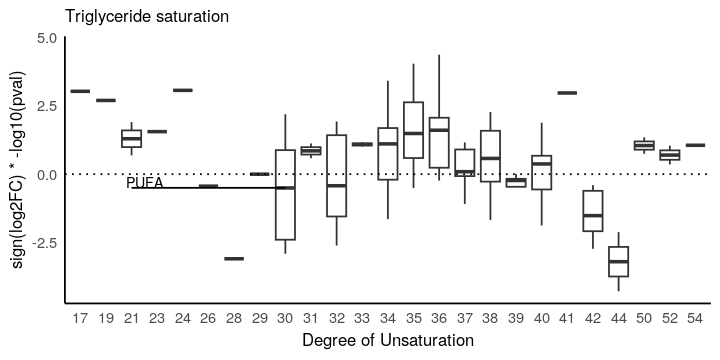

In [10]:
# Adjust figure size
options(repr.plot.width = 6, repr.plot.height = 3)

# Extract row data for PCs
x = as.data.frame(rowData(data$ngn2_all))
x$logfc = x$logfc_both_batch
x$fdr = p.adjust(x$pvals_both_batch, method = "fdr")

x = x[x$lipid.class == 'PC',]
# Compute Spearman correlation between total_unsaturation and score_both_batch

result <- cor.test(x$total_unsaturation, x$score_both_batch, method = "spearman")
# Add p-value and rho to the plot
p_value <- result$p.value
rho <- result$estimate

# Plot boxplot of sign(logFC both batch) * -log10(pval both batch) against total unsaturation
ggplot(x, aes(x = as.factor(total_length), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA) +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
  labs(x = "Degree of Unsaturation", y = "sign(log2FC) * -log10(pval)", title = "Triglyceride saturation") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(), 
    axis.line = element_line(color = "black"),
    plot.title = element_text(size = 10),  # Change title font size
    axis.title.x = element_text(size = 10),  # Change x label font size
    axis.title.y = element_text(size = 10)   # Change y label font size
  ) +
  # geom_jitter(
  #   data = filter(x, fdr<0.05 & abs(logfc_both_batch)>1),  # Filter data for TRUE annotations
  #   width = 0.2,                            # Horizontal jitter
  #   size = 1,                               # Increased size for visibility
  #   alpha = 0.7,                            # Slightly higher opacity
  #   color = "red"                           # Color for annotated points
  # ) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "black") +
  annotate("segment", x = 3, xend = 9, y = -0.5, yend = -0.5,  color = "black") +  # Add right arrow
  annotate("text", x = 3.5, y = -.3, label = "PUFA", color = "black", size = 3)  # Add horizontal dotted line at zero
#ggsave("./pdf_figures/triglycerides_saturation.pdf", plot = last_plot(), device = "pdf", width = 3, height = 3)

# Add right arrow annotation to the plot




Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

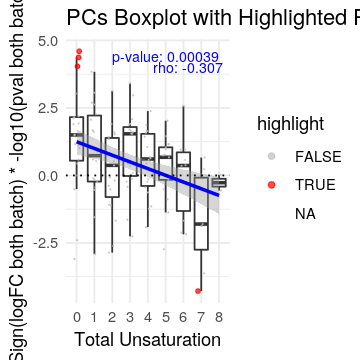

In [225]:
library(ggplot2)
# Add a new column 'highlight' to indicate if the absolute y-value > 3
x$highlight <- abs(x$score_both_batch) > 4

ggplot(x, aes(x = as.factor(total_unsaturation), y = score_both_batch)) +
  geom_boxplot(outlier.shape = NA) +
  
  # Plot individual data points, mapping color to the 'highlight' variable
  geom_jitter(aes(color = highlight), width = 0.2, size = ifelse(x$highlight, 1, 0), alpha = 0.7) +
  
  # Customize colors to make highlighted points stand out
  scale_color_manual(values = c("FALSE" = "grey", "TRUE" = "red")) +
  
  geom_smooth(method = "lm", aes(group = 1), color = "blue", se = TRUE) +  # Add trend line
  
  labs(
    x = "Total Unsaturation",
    y = "Sign(logFC both batch) * -log10(pval both batch)",
    title = "PCs Boxplot with Highlighted Points"
  ) +
  theme_minimal() +
  
  # Adjust annotations to avoid overlapping with data
  annotate(
    "text", x = Inf, y = Inf,
    label = paste("p-value:", format(p_value, digits = 3)),
    hjust = 1.1, vjust = 2.1, size = 3, color = "blue"
  ) +
  annotate(
    "text", x = Inf, y = Inf,
    label = paste("rho:", format(rho, digits = 3)),
    hjust = 1.1, vjust = 3.1, size = 3, color = "blue"
  ) +
  
  geom_hline(yintercept = 0, linetype = "dotted", color = "black")   # Add horizontal dotted line at zero


In [35]:
x = as.data.frame(rowData(data$pm_all))
x = x[x$lipid.class == 'PC',]

names(x)

[1] "lipid.name"         "lipid.lipidion"     "lipid.key"         
 [4] "lipid.Class"        "lipid.Subclass"     "lipid.fattyacid"   
 [7] "lipid.fa1"          "lipid.fa2"          "lipid.fa3"         
[10] "lipid.calcmz"       "lipid.ionformula"   "stats."            
[13] "stats.CON"          "stats.LOF"          "stats..1"          
[16] "stats.ratio"        "stats.log2"         "stats.pvalue"      
[19] "total_unsaturation" "mean_length"        "total_length"      
[22] "names"              "merge_index"        "max_length"        
[25] "min_length"         "lipid.class"

In [26]:
# Plot ratios

## PC/total
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_PC_total.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = PC/total)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "PC/total", title = "") +
  theme_minimal() + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

## TG/total
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_TG_total.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = TG/total)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "TG/total", title = "") +
  theme_minimal() + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

## PC/TG
options(repr.plot.width = 2.5, repr.plot.height = 3)

pdf('../pdf_figures/pm_pc_to_tg.pdf', width=2.5, height=3)
ggplot(df, aes(x = genotype, y = PC/TG)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "PC:TG", title = "") +
  theme_minimal() +   geom_jitter(width=.1) + geom_signif(comparisons = list(c("CON", "LOF")), textsize = 5, test = "t.test", map_signif_level = F) #+ ylim(c(0,1.5e+13))
dev.off()

png 
  2

In [221]:
## Volcano plot
plot_volcano = function(sce, ratio_name, pval_name, pval_cut, lfc_cut, adjust, annotation1, class_cols){
    cols = c('dodgerblue2', 'grey', 'red')
    names(cols) = c('down', 'other', 'up')
    temp = as.data.frame(rowData(sce)[,c(ratio_name, pval_name, annotation1)])
    colnames(temp) = c('log2', 'pvalue', 'label')
    if(adjust){
        temp$pvalue = p.adjust(temp$pvalue, 'fdr')
    }
    temp$direction = ifelse(temp$log2>lfc_cut & temp$pvalue<pval_cut, 'up', ifelse(temp$log2< -1*lfc_cut & temp$pvalue<pval_cut, 'down', 'other'))
    temp$label2 = ifelse(temp$direction!='other', temp$label,'')
    p = ggplot(temp, aes(x=log2, y= -log10(pvalue), col=direction, label = label2))+ geom_text_repel(max.overlaps = Inf, size = 3.5)+  scale_color_manual(values = cols) + geom_point(aes(alpha = 0.01), size = 2, show.legend = FALSE)+theme_classic() +   theme(text = element_text(size=10),strip.background = element_blank(),strip.placement = "outside" ,strip.text.y = element_text(size = 10, color = "black"))+ theme(legend.position='none')#+ #facet_wrap(~label, ncol = 7, scales = "free_x")
    return(p+xlab('log2(fold change)')+ylab('-log10(p-value)'))
}

options(repr.plot.width = 5, repr.plot.height = 4)

# show the top lipid species
library(ggrepel)

pdf('../pdf_figures/pm_volcano.pdf', width=5, height=4)
plot_volcano(data$pm_all, 'stats.log2', 'stats.pvalue',  0.1, 1, FALSE, 'lipid.key', c('brown1'))+xlim(c(-4,4))
dev.off()

**NGN2 Lipidomics By Subclass**

In [2]:
# load the iN lipidomics data
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$ngn2_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

# sum by lipid class
result <- aggregate(. ~ class, data = cts[cts$class %in% unique(class), ], sum)
rownames(result) = result$class
result$class = NULL
df =  as.data.frame(t(result))
total = rowSums(df)
df = as.data.frame(cbind(df, colData(d)[,c('Genotype', 'treatment', 'Cell counts')], total))

df2 = df[df$treatment!='Choline',]
df2$grp = paste0(df2$Genotype, df2$treatment)
df2$Genotype = factor(df2$Genotype, levels = c('Control', 'ABCA7 LoF'))

# load key info
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
key = read.csv('../../ABCA7lof//raw_data/ngn2_data/lipidkey.csv', sep = '\t')
key = key[!duplicated(key$Key),]
rownames(key) = key$Key
rowData(data$ngn2_all)$Class = as.character(key[rowData(data$ngn2_all)$lipid.class,'Class'])

In [679]:
# plot volcano for subclasses

plot_volcano = function(sce, ratio_name, pval_name, pval_cut, lfc_cut, adjust, annotation1, cols){
    temp = as.data.frame(rowData(sce)[,c(ratio_name, pval_name, annotation1)])
    colnames(temp) = c('log2', 'pvalue', 'label')
    if(adjust){
        temp$pvalue = p.adjust(temp$pvalue, 'fdr')
    }
    temp$direction = ifelse(temp$log2>lfc_cut & temp$pvalue<pval_cut, 'up', ifelse(temp$log2< -1*lfc_cut & temp$pvalue<pval_cut, 'down', 'other'))
    labs = temp$label[temp$direction!='other']
    temp$label2 = ifelse(temp$label%in%labs, temp$label, 'other')#temp$direction!='other' | temp$, temp$label,'other')
    temp$rank = rank(temp$log2)
    temp = temp[temp$label2!='other',]
    p = ggplot(temp, aes(x=log2, y=-log10(pvalue), col=label2))+   scale_color_manual(values = cols) +  geom_point(aes(alpha = ifelse(temp$direction!='other', .4, 0)), size=2) + geom_point(aes(alpha = 1),shape=21,stroke=ifelse(temp$direction=='other', 0, .6), size = 2, show.legend = TRUE)+theme_classic() +   theme(text = element_text(size=10),strip.background = element_blank(),strip.placement = "outside" ,strip.text.y = element_text(size = 10, color = "black"))+ theme(legend.position='right')#+facet_grid(label2 ~ . , scales="free", space="free")
#+ #facet_wrap(~label, ncol = 7, scales = "free_x")
    return(p+xlab('log2(fold change)')+ylab('-log10(p-value)'))
}

cols = pal_npg("nrc")(10)
names(cols) = c('DG', 'Cer', 'CL', 'Hex1Cer', 'MG', 'MLCL', 'PC', 'PG', 'PS', 'other')
cols['other'] = 'lightgrey'

cols = c('gold', 'red', 'purple', 'green', 'black')
names(cols) = unique(rowData(data$ngn2_all)$Class)

options(repr.plot.width =7, repr.plot.height = 4)

#pdf('../pdf_figures/major_class_lipid_in.pdf', width=7, height=4)
plot_volcano(data$ngn2_all, 'logfc_both_batch', 'pvals_both_batch',  0.005, 0, FALSE, 'Class', cols) + xlim(-5,5) + geom_hline(yintercept=-log10(0.005),  linetype='dashed')+ geom_vline(xintercept=0, linetype='dashed')
#dev.off()

Warning message:
“Use of `temp$direction` is discouraged. Use `direction` instead.”Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_point).”

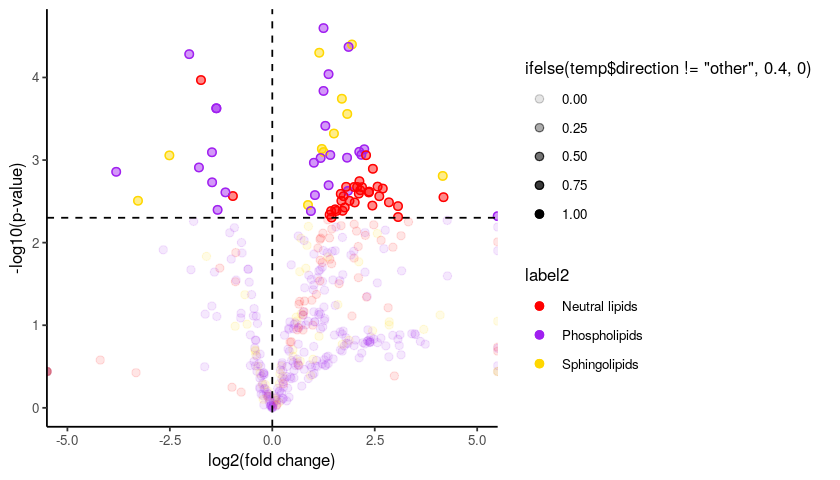

In [10]:
## Plot ratios
library(reshape2)

T = df[, 1:31]/df$total
T$Genotype = df$Genotype
T[,'PC:TG'] = T$PC/T$TG
T[,'CL:TG'] = T$CL/T$TG

T[,'MG:TG'] = T$MG/T$TG
T[,'LPC:PC'] = T$LPC/T$PC

### Nr 1

x = melt(T)
x = x[as.character(x$variable)%in%c('DG', 'PC', 'TG'),]

options(repr.plot.width = 10, repr.plot.height = 2.5)

cols = c('grey', 'blue')
names(cols) = c('Control', 'ABCA7 LoF')
x$Genotype = factor(x$Genotype, levels=c('Control', 'ABCA7 LoF'))

pdf('../pdf_figures/ratios_iN3.pdf', width=5, height = 2.5)
ggplot(x, aes(x = Genotype, y = value)) +
  geom_boxplot(aes(color=Genotype, fill=Genotype, alpha=.5)) +
  labs(x = "", y = "sum subclass/total", title = "") +
  theme_classic() + geom_jitter(aes(color=Genotype), width=.1) + scale_y_continuous(limits = c(0, NA)) + geom_signif(comparisons = list(c("Control", "ABCA7 LoF")), textsize = 3, test = "t.test", map_signif_level = F) + scale_fill_manual(values = cols)  + scale_color_manual(values = cols) + facet_wrap(~variable, nrow=1, scales = "free") +   theme(
    axis.text.x = element_blank(),  # Remove x-axis labels
    axis.ticks.x = element_blank() , strip.background = element_rect(fill = "white", color = NA)) + coord_cartesian(clip = "off")
dev.off()
# Remove x-axis ticks

#+ ylim(c(0,1.5e+13))

### Nr 2 

x = melt(T)
x = x[as.character(x$variable)%in%c('PC:TG', 'MG:TG', 'LPC:PC'),]

options(repr.plot.width = 5, repr.plot.height = 2.5)

cols = c('grey', 'blue')
names(cols) = c('Control', 'ABCA7 LoF')
x$Genotype = factor(x$Genotype, levels=c('Control', 'ABCA7 LoF'))
pdf('../pdf_figures/ratios2_iN.pdf', width=5, height = 2.5)

ggplot(x, aes(x = Genotype, y = value)) +
  geom_boxplot(aes(color=Genotype, fill=Genotype, alpha=.5)) +
  labs(x = "", y = "Ratio subclass # 1 / subclass #2", title = "") +
  theme_classic() + geom_jitter(aes(color=Genotype), width=.1) + scale_y_continuous(limits = c(0, NA)) + geom_signif(comparisons = list(c("Control", "ABCA7 LoF")), textsize = 3, test = "t.test", map_signif_level = F) + scale_fill_manual(values = cols)  + scale_color_manual(values = cols) + facet_wrap(~variable, nrow=1, scales = "free") +   theme(
    axis.text.x = element_blank(),  # Remove x-axis labels
    axis.ticks.x = element_blank() , strip.background = element_rect(fill = "white", color = NA)) 

dev.off()
# Remove x-axis ticks
#+ ylim(c(0,1.5e+13))

Warning message:
“Following annotation names are duplicated: foo, label”Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“supplied color is neither numeric nor character”

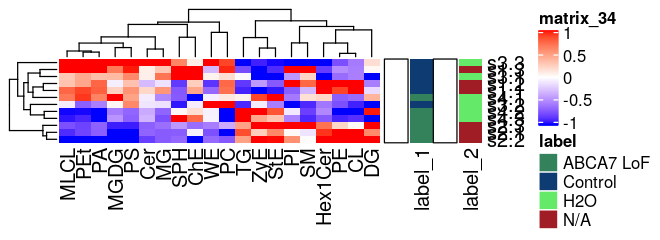

In [173]:
### Plot heatmap - main classes 

options(repr.plot.width = 5.5, repr.plot.height = 2)

df2 = df2[df2$treatment!='Choline',]

category_colors <- list('Control' = "blue", 'ABCA7 LoF' = "red")

row_annotation <- rowAnnotation(foo = anno_block(gp = gpar(fill = category_colors[as.character(df2$Genotype)])), label=as.character(df2$Genotype))

category_colors <- list('N/A' = "blue", 'H2O' = "blue", "Choline" = 'red')
row_annotation2 <- rowAnnotation(foo = anno_block(gp = gpar(fill = category_colors[as.character(df2$treatment)])), label=as.character(df2$treatment))

library(ComplexHeatmap)
library(circlize)
temp = df2[,1:31]/df2$total

Heatmap((scale((temp[,colMeans(temp)>0.001]
))),right_annotation = c(row_annotation, row_annotation2),        col = colorRamp2(c(-1, 0, 1), c("blue", "white", "red")))

#### Power analysis, lipidomics Y622

In [172]:
# load the iN lipidomics data
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$ngn2_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

In [183]:
colData(data$ngn2_all)$Genotype

[1] "Control"   "Control"   "Control"   "ABCA7 LoF" "ABCA7 LoF" "ABCA7 LoF"
 [7] "Control"   "Control"   "Control"   "ABCA7 LoF" "ABCA7 LoF" "ABCA7 LoF"
[13] "ABCA7 LoF" "ABCA7 LoF" "ABCA7 LoF"

In [156]:
library(effsize)
library(pwr)

# load the iN lipidomics data
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
d = data$ngn2_all
cts = assays(d)$counts
class = rowData(d)$lipid.class
cts$class = class

# sum by lipid class
result <- aggregate(. ~ class, data = cts[cts$class %in% unique(class), ], sum)
rownames(result) = result$class
result$class = NULL
df =  as.data.frame(t(result))
total = rowSums(df)
df = as.data.frame(cbind(df, colData(d)[,c('Genotype', 'treatment', 'Cell counts')], total))

df2 = df[df$treatment!='Choline',]
df2$grp = paste0(df2$Genotype, df2$treatment)
df2$Genotype = factor(df2$Genotype, levels = c('Control', 'ABCA7 LoF'))

# load key info
data = readRDS('../../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
key = read.csv('../../ABCA7lof//raw_data/ngn2_data/lipidkey.csv', sep = '\t')
key = key[!duplicated(key$Key),]
rownames(key) = key$Key
rowData(data$ngn2_all)$Class = as.character(key[rowData(data$ngn2_all)$lipid.class,'Class'])

x = df[(df$treatment!='Choline') & (df$Genotype=='Control'),]
no_treat_pc = x$PC/x$total

x = df[(df$treatment!='Choline') & (df$Genotype=='ABCA7 LoF'),]
treat_pc = x$PC/x$total

s = cohen.d(no_treat_pc, treat_pc)

calculate_power_unbalanced <- function(n1, n2, effect_size, alpha) {
  # Load the pwr package
  library(pwr)
  
  result <- pwr.t2n.test(n1 = n1, n2 = n2, d = effect_size, sig.level = alpha)

  # Return the power
  return(result$power)
}

# Example usage
n1 <- 8        # Sample size for group 1
n2 <- 4        # Sample size for group 2
effect_size <- s$estimate/2  # Medium effect size (Cohen's d)
alpha <- 0.05   # Significance level

power <- calculate_power_unbalanced(n1, n2, effect_size, alpha)
print(paste("Power:", power))


[1] "Power: 0.62061696719429"


null device 
          1

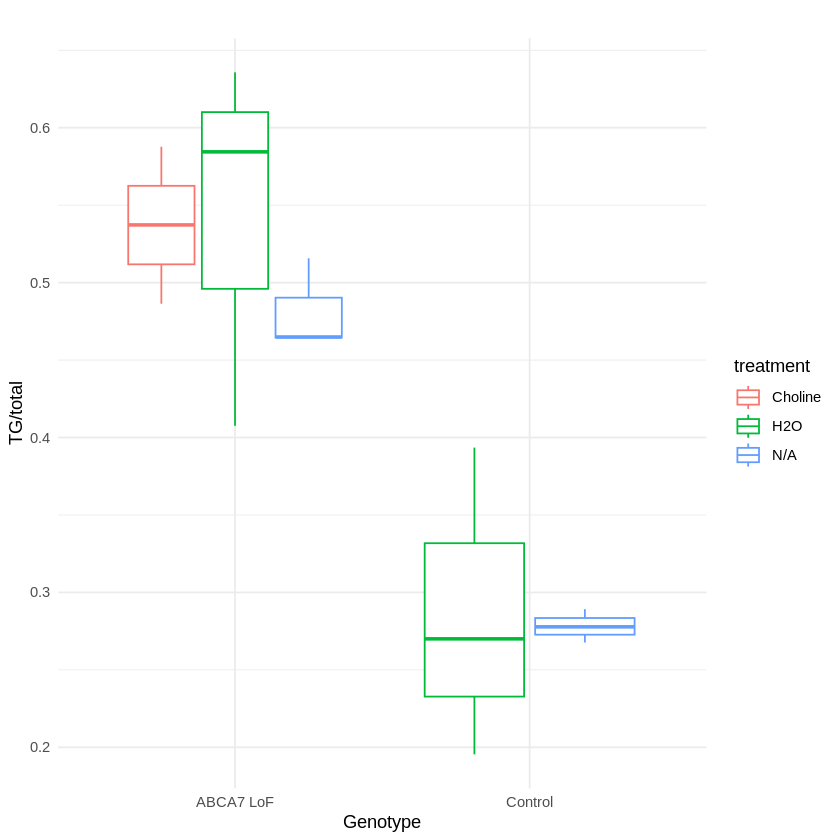

In [166]:
ggplot(df, aes(x = Genotype, y = TG/total, col = treatment)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "TG/total", title = "") +
  theme_minimal() #+ ylim(c(0,1.5e+13))
dev.off()


null device 
          1

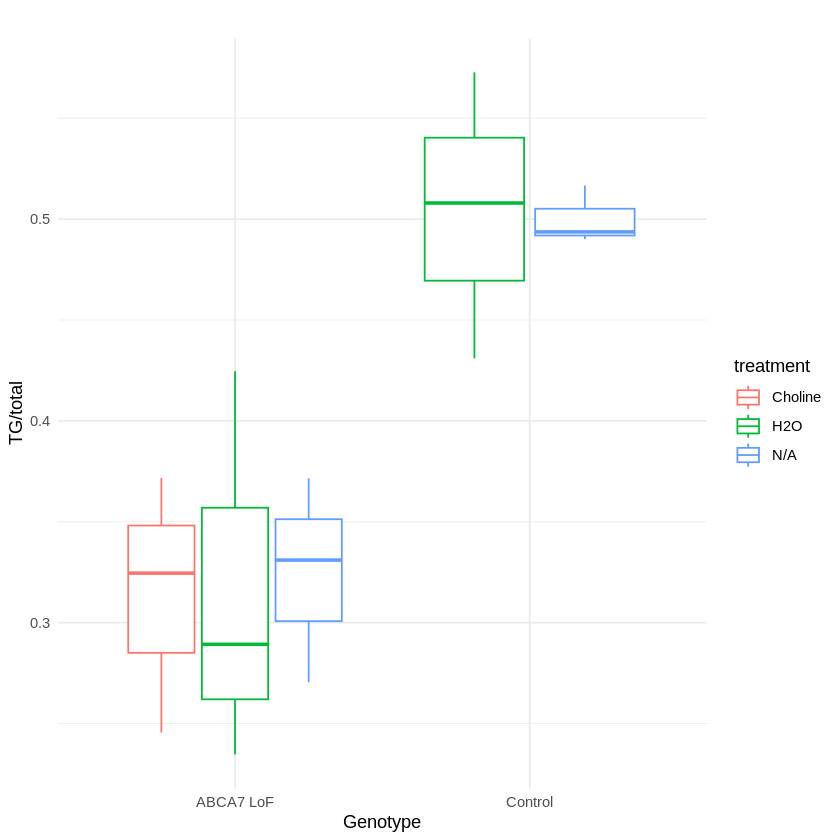

In [171]:
ggplot(df, aes(x = Genotype, y = PC/total, col = treatment)) +
  geom_boxplot(outlier.shape = 1) +
  labs(x = "Genotype", y = "TG/total", title = "") +
  theme_minimal() #+ ylim(c(0,1.5e+13))
dev.off()


In [165]:
df

,Cer,ChE,CL,Co,DG,DGDG,DLCL,FA,Hex1Cer,Hex2Cer,⋯,SQDG,ST,StE,TG,WE,ZyE,Genotype,treatment,Cell counts,total
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
s1.1,3702638933,591029131,1768772991,0,943418112,16752314,0.0,0,465514498,0.0,⋯,30122884,0,46419304,16655283239,23085734,70486177,Control,N/A,395200,62231528210
s1.2,5407041856,1146440499,3618691385,0,1816871876,20411920,0.0,0,907496987,3641977.9,⋯,35363193,0,112450485,34530945724,5159899,263034345,Control,N/A,395200,124316630811
s1.3,5533459217,1076172373,979251047,0,1539347547,14489368,956677.3,0,481353783,2756334.2,⋯,22465223,0,78252001,28848806557,88454166,159853362,Control,N/A,395200,99767748086
s2.1,6121670048,1697736106,6891035239,0,3131755006,19088219,0.0,0,1369048889,12670596.3,⋯,30670514,0,340725199,99772307353,41171296,530828893,ABCA7 LoF,N/A,424000,193483117090
s2.2,5973510801,1598589490,7280455831,0,3898772470,22605288,0.0,2494466,1665561236,13809474.9,⋯,36620029,0,454292265,104964544732,82532401,850765398,ABCA7 LoF,N/A,434000,225784169670
s2.3,7921621319,2047895987,4278658267,107376815,4348523042,17314463,0.0,0,1738699455,19088814.1,⋯,27567211,0,558088995,118920411253,127907335,873008505,ABCA7 LoF,N/A,444000,256138770408
s3.1,4683058840,878951839,835750120,0,1183674515,19344485,0.0,0,331208728,189017.4,⋯,31151502,0,44259978,33242001004,122448979,125556711,Control,H2O,395200,84477434753
s3.2,3899455962,692914800,432954511,0,1023382588,14220241,0.0,0,406437239,0.0,⋯,28838486,78081979,79578300,21346236326,414022639,192133436,Control,H2O,395200,79056163502
s3.3,9308883116,565771756,606315472,0,983766274,24251070,0.0,739229703,280067493,0.0,⋯,31877716,0,45751927,12319187351,214267748,105156481,Control,H2O,395200,63026130073
